In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn import metrics
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np


dataset = pd.read_excel('DATA/cdicandnormal.xlsx', header=None)

feature_names = dataset.iloc[0,0:76]
# attributes
X = dataset.iloc[1:80, 0:76]

# label(result)
y = dataset.iloc[1:80, 76]

In [3]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 4)
# Scaling to bring values to the same range

from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)


#print ('Train set:', X_train.shape,  y_train.shape)
#print ('Test set:', X_test.shape,  y_test.shape)


In [3]:
########################################### KNN MODEL ############################################################
from sklearn.neighbors import KNeighborsClassifier
Ks = 10
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
for n in range(1,Ks):
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat = neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)
    std_acc[n-1] = np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

mean_acc

array([0.79166667, 0.70833333, 0.70833333, 0.75      , 0.83333333,
       0.79166667, 0.83333333, 0.79166667, 0.875     ])

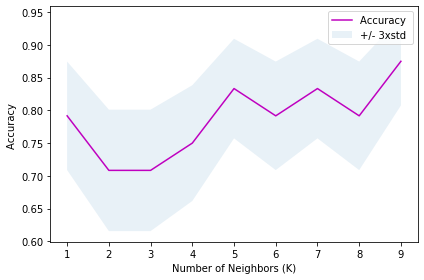

In [4]:
plt.plot(range(1,Ks),mean_acc,'m')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

In [ ]:
yhat = neigh.predict(X_test)

In [ ]:
################################################## DECISION TRESS ##################################################################################
from sklearn.tree import DecisionTreeClassifier
max_depth = 10
mean_acc = np.zeros((max_depth-1))
std_acc = np.zeros((max_depth-1))
for n in range(1,max_depth):
    dec = DecisionTreeClassifier(criterion='entropy', max_depth=n).fit(X_train,y_train)
    yhat = dec.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)
    std_acc[n-1] = np.std(yhat==y_test)/np.sqrt(yhat.shape[0])
    
    mean_acc

In [ ]:
plt.plot(range(1,max_depth),mean_acc,'g')
plt.fill_between(range(1,max_depth),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Max Depth')
plt.tight_layout()
plt.show()

In [ ]:
# depth 1 or 2 seems overly simplistic, let's choose depth = 6 as the best model
dec_tree_model = DecisionTreeClassifier(criterion='entropy', max_depth=6).fit(X,y)

In [4]:
################################################ SVM ##########################################3

from sklearn import svm

kernels = ['linear', 'poly', 'rbf', 'sigmoid']
mean_acc = {}
std_acc = {}

for k in kernels:
    neigh = svm.SVC(kernel=k, cache_size=7000).fit(X_train,y_train)
    yhat = neigh.predict(X_test)
    mean_acc[k] = metrics.accuracy_score(y_test, yhat)
    std_acc[k] = np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

mean_acc

{'linear': 0.9166666666666666,
 'poly': 0.375,
 'rbf': 0.9166666666666666,
 'sigmoid': 0.7083333333333334}

In [12]:
# the linear model seem to give the best result
from sklearn.metrics import accuracy_score
clf = svm.SVC(kernel='rbf', cache_size=7000)
clf.fit(X_train,y_train)
yhat = clf.predict(X_test)
accuracy = accuracy_score(y_test, yhat.round())
accuracy

0.9166666666666666

In [ ]:
######################################################## LOGISTIC REGRESSION ##################################################
from sklearn.linear_model import LogisticRegression
solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
regularisations = [1, 0.3, 0.1, 0.03, 0.01, 0.003, 0.001]
solver_mean_acc = {}
solver_std_acc = {}
solver_best_reg = {}
for solver in solvers:
    best_mean = 0
    best_std = 0
    best_reg = 0
    for reg in regularisations:
        lr = LogisticRegression(C=reg, solver=solver).fit(X_train, y_train)
        yhat = lr.predict(X_test)
        mean = metrics.accuracy_score(y_test, yhat)
        std = np.std(yhat==y_test)/np.sqrt(yhat.shape[0])
        if mean > best_mean:
            best_mean = mean
            best_std = std
            best_reg = reg
    solver_mean_acc[solver] = best_mean
    solver_std_acc[solver] = best_std
    solver_best_reg[solver] = best_reg

solver_mean_acc

In [ ]:
solver_best_reg

In [ ]:
lr_model = LogisticRegression(C=0.3, solver='lbfgs').fit(X, y)

In [ ]:
############################################### RANDOM FOREST ##################################################################
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

from pprint import pprint
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 100, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train,y_train)

In [ ]:
rf_random.best_params_

In [ ]:
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
def evaluate(model, X_test, y_test):
    yhat = model.predict(X_test)
   # accuracy: (tp + tn) / (p + n)
    accuracy = accuracy_score(y_test, yhat.round())
    print('Accuracy: %f' % accuracy)
    # precision tp / (tp + fp)
    precision = precision_score(y_test, yhat.round())
    print('Precision: %f' % precision)
    # recall: tp / (tp + fn)
    recall = recall_score(y_test, yhat.round())
    print('Recall: %f' % recall)
    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(y_test, yhat.round(),'weighted')
    print('F1 score: %f' % f1)
    # Jaccard Index
    jaccard=jaccard_score(y_test, yhat.round(),'weighted')
    print('Jaccard: %f' % jaccard)
    # kappa
    kappa = cohen_kappa_score(y_test, yhat.round())
    print('Cohens kappa: %f' % kappa)
    # ROC AUC
    auc = roc_auc_score(y_test, yhat.round())
    print('ROC AUC: %f' % auc)
    # confusion matrix
    matrix = confusion_matrix(y_test, yhat.round())
    print(matrix)
    
    return accuracy,precision,recall,f1,jaccard,kappa,auc,matrix

In [ ]:
################################################# NAIVE BAYES ##############################################
from sklearn.naive_bayes import GaussianNB

#Create a Gaussian Classifier
gnb = GaussianNB()

#Train the model using the training sets
gnb.fit(X_train, y_train)

#Predict the response for test dataset
yhat = gnb.predict(X_test)


In [ ]:
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

In [ ]:
df = pd.DataFrame(index=['KNN', 'Decision Tree', 'SVM', 'Logistic Regression','Random Forest', 'Naive Bayes'], 
                  columns=['Accuracy','Precision','Recall','Kappa','Jaccard', 'F1-score', 'ROC','Confusion Matrix', 'LogLoss'])

# -------------------------------------------TABLE CREATION--------------------------------------------------------

# -------------------------------------------------KNN----------------------------------------------------------------
yhat = neigh.predict(X_test)
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, yhat.round())
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, yhat.round())
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, yhat.round())
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, yhat.round(),'weighted')
print('F1 score: %f' % f1)
# Jaccard Index
jaccard=jaccard_score(y_test, yhat.round(),'weighted')
print('Jaccard: %f' % jaccard)
# kappa
kappa = cohen_kappa_score(y_test, yhat.round())
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_test, yhat.round())
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(y_test, yhat.round())
print(matrix)

df.loc['KNN'] = [accuracy, precision, recall, kappa, jaccard, f1, auc, matrix, np.nan]

# -------------------------------------------------DECISION TREE----------------------------------------------------
yhat = dec_tree_model.predict(X_test)
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, yhat.round())
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, yhat.round())
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, yhat.round())
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, yhat.round(),'weighted')
print('F1 score: %f' % f1)
# Jaccard Index
jaccard=jaccard_score(y_test, yhat.round(),'weighted')
print('Jaccard: %f' % jaccard)
# kappa
kappa = cohen_kappa_score(y_test, yhat.round())
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_test, yhat.round())
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(y_test, yhat.round())
print(matrix)
df.loc['Decision Tree'] = [accuracy, precision, recall, kappa, jaccard, f1, auc, matrix,np.nan]

# ------------------------------------------------------SVM------------------------------------------------------------
yhat = svm_model.predict(X_test)
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, yhat.round())
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, yhat.round())
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, yhat.round())
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, yhat.round(),'weighted')
print('F1 score: %f' % f1)
# Jaccard Index
jaccard=jaccard_score(y_test, yhat.round(),'weighted')
print('Jaccard: %f' % jaccard)
# kappa
kappa = cohen_kappa_score(y_test, yhat.round())
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_test, yhat.round())
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(y_test, yhat.round())
print(matrix)
df.loc['SVM'] = [accuracy, precision, recall, kappa, jaccard, f1, auc, matrix,np.nan]


# ----------------------------------------------------LOGISTIC REGRESSION ---------------------------------------------------------

yhat = lr_model.predict(X_test)
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, yhat.round())
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, yhat.round())
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, yhat.round())
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, yhat.round(),'weighted')
print('F1 score: %f' % f1)
# Jaccard Index
jaccard=jaccard_score(y_test, yhat.round(),'weighted')
print('Jaccard: %f' % jaccard)
# kappa
kappa = cohen_kappa_score(y_test, yhat.round())
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_test, yhat.round())
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(y_test, yhat.round())
print(matrix)
yhat_prob = lr_model.predict_proba(X_test)
ll = log_loss(y_test, yhat_prob)
df.loc['Logistic Regression'] = [accuracy, precision, recall, kappa, jaccard, f1, auc, matrix,np.nan]

# ----------------------------------------------------- RANDOM FOREST ---------------------------------------------------------
yhat = rf_random.predict(X_test)
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, yhat.round())
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, yhat.round())
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, yhat.round())
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, yhat.round(),'weighted')
print('F1 score: %f' % f1)
# Jaccard Index
jaccard=jaccard_score(y_test, yhat.round(),'weighted')
print('Jaccard: %f' % jaccard)
# kappa
kappa = cohen_kappa_score(y_test, yhat.round())
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_test, yhat.round())
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(y_test, yhat.round())
print(matrix)
df.loc['Random Forest'] = [accuracy, precision, recall, kappa, jaccard, f1, auc, matrix,np.nan]


# ----------------------------------------------------- NAIVE BAYES -----------------------------------------------------------
yhat = gnb.predict(X_test)
 # accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, yhat.round())
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, yhat.round())
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, yhat.round())
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, yhat.round(),'weighted')
print('F1 score: %f' % f1)
# Jaccard Index
jaccard=jaccard_score(y_test, yhat.round(),'weighted')
print('Jaccard: %f' % jaccard)
# kappa
kappa = cohen_kappa_score(y_test, yhat.round())
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_test, yhat.round())
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(y_test, yhat.round())
print(matrix)
df.loc['Naive Bayes'] = [accuracy, precision, recall, kappa, jaccard, f1, auc, matrix,np.nan]


In [ ]:
df